In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd

from statsmodels.stats.anova import AnovaRM

from vr2f.staticinfo import PATHS
from vr2f.utils.access_keeper import copy_to_keeper
from vr2f.behavior.maintask import plot_confusion_matrix, get_confusion_matrix

Matplotlib is building the font cache; this may take a moment.


In [2]:
%reload_ext autoreload
%autoreload 2

In [57]:
def format_float(x):
    return f"{x:.2f}"



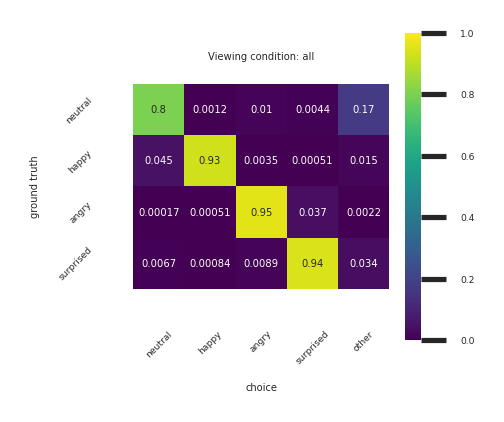

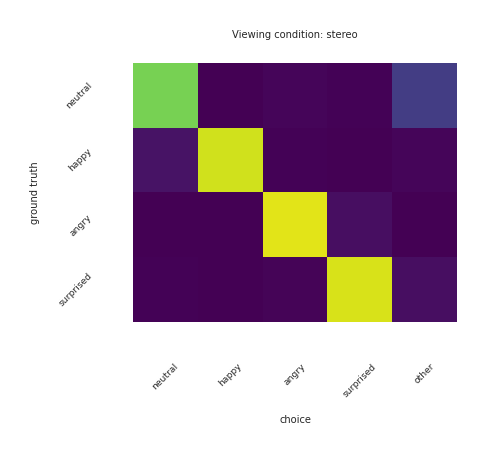

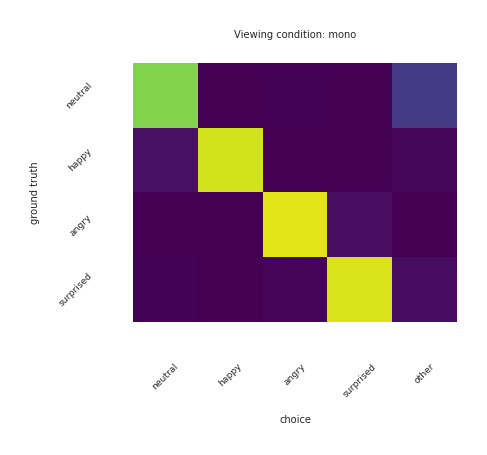

In [3]:
paths = PATHS()

path_subs = paths.DATA_SUBJECTS
sub_list_str = sorted(os.listdir(path_subs))

subs_incomplete = ["VR2FEM_S09"]
sub_list_str = [s for s in sub_list_str if s not in subs_incomplete]

cfs = {"all": [], "stereo": [], "mono": []}
for sub_id in sub_list_str:
    for cond in cfs:
        cf = get_confusion_matrix(sub_id, cond)
        cfs[cond].append(cf)

# Average across subjects
cf_avg = {}
for cond in cfs:
    cf_avg[cond] = np.array(cfs[cond]).mean(axis=0)
    o = plot_confusion_matrix(cf_avg, cond, save_to_disk=False, figsize_factor=0.2)



In [34]:


emotions = ["neutral", "angry", "happy", "surprised"]

df_accs = pd.DataFrame(columns=["sub_id", "viewcond", "emotion", "acc"])
for cond in ["all", "stereo", "mono"]:
  for idx, cf in enumerate(cfs[cond]):
    accs = np.diagonal(cf)[:-1]
    df = pd.DataFrame(columns=["sub_id", "viewcond", "emotion", "acc"])
    df["sub_id"] = [sub_list_str[idx]] * len(accs)
    df["viewcond"] = [cond] * len(accs)
    df["emotion"] = emotions
    df["acc"] = accs
    df_accs = df if df_accs.empty else pd.concat([df_accs, df])

convert_dict = {"sub_id": str, "viewcond": str, "emotion": str, "acc": float}
df_accs = df_accs.astype(convert_dict)

paths = PATHS()
df_accs.to_csv(Path(paths.RESULTS, "dataframes", "behavior", "behavior_accs.csv"), index=False)

In [80]:
aov = AnovaRM(df_accs,
          depvar = "acc",
          subject = "sub_id",
          within = ["viewcond", "emotion"]).fit()
print(aov)


                     Anova
                 F Value Num DF  Den DF  Pr > F
-----------------------------------------------
viewcond          1.8510 2.0000  64.0000 0.1654
emotion           6.8133 3.0000  96.0000 0.0003
viewcond:emotion  1.3658 6.0000 192.0000 0.2303



In [32]:
summary = df_accs.groupby(["viewcond", "emotion"]).agg({"acc": ["mean", "std", "sem", "min", "max"]}).reset_index()
summary.loc[:, ("acc", "ci_lower")] = summary[("acc", "mean")] - 1.96 * summary[("acc", "sem")]
summary.loc[:, ("acc", "ci_upper")] = summary[("acc", "mean")] + 1.96 * summary[("acc", "sem")]

summary

viewcond    emotion       acc                                               \
                            mean       std       sem       min  max  ci_lower   
0       all      angry  0.929293  0.151817  0.026428  0.222222  1.0  0.877494   
1       all      happy  0.954882  0.058840  0.010243  0.777778  1.0  0.934807   
2       all    neutral  0.803199  0.251155  0.043720  0.144444  1.0  0.717507   
3       all  surprised  0.941919  0.114008  0.019846  0.438889  1.0  0.903020   
4      mono      angry  0.930640  0.147302  0.025642  0.222222  1.0  0.880382   
5      mono      happy  0.954545  0.062938  0.010956  0.733333  1.0  0.933072   
6      mono    neutral  0.810438  0.252273  0.043915  0.122222  1.0  0.724364   
7      mono  surprised  0.942761  0.110558  0.019246  0.500000  1.0  0.905039   
8    stereo      angry  0.927946  0.158239  0.027546  0.222222  1.0  0.873956   
9    stereo      happy  0.955219  0.058365  0.010160  0.800000  1.0  0.935305   
10   stereo    neutral  0.795960  0.251398  0.043763  0.166667  1.0  0.710185   
11   stereo  surprised  0.941077  0.120008  0.020891  0.377778  1.0  0.900132   

              
    ci_upper  
0   0.981092  
1   0.974958  
2   0.888891  
3   0.980818  
4   0.980898  
5   0.976019  
6   0.896511  
7   0.980483  
8   0.981936  
9   0.975133  
10  0.881735  
11  0.982023

In [78]:
summary = df_accs.groupby(["viewcond"]).agg({"acc": ["mean", "std", "sem", "min", "max"]}).reset_index()
summary.loc[:, ("acc", "ci_lower")] = summary[("acc", "mean")] - 1.96 * summary[("acc", "sem")]
summary.loc[:, ("acc", "ci_upper")] = summary[("acc", "mean")] + 1.96 * summary[("acc", "sem")]
m = {}
sd = {}
ci_l = {}
ci_u = {}
for vc in ["stereo", "mono"]:
  m[vc], sd[vc], ci_l[vc], ci_u[vc] = summary.loc[summary["viewcond"] == vc, ("acc", ("mean", "std", "ci_lower", "ci_upper"))].values[0]
  m[vc], sd[vc], ci_l[vc], ci_u[vc] = format_float(m[vc] * 100), format_float(sd[vc] * 100), format_float(ci_l[vc] * 100), format_float(ci_u[vc] * 100)


txt = f"""
We did not observe a difference in recognition rate for the mono- (M = {m['mono']} %, SD = {sd['mono']}, 95% CI [{ci_l['mono']}, {ci_u['mono']}])
and the stereoscopic viewing conditions (M = {m['stereo']} %, SD = {sd['stereo']}, 95% CI [{ci_l['stereo']}, {ci_u['stereo']}]), as indicated by a non-significant main effect of viewing condition
(F(2, 64) = 1.85, p = .165) and a non-significant interaction (F(6, 192) = 1.37, p = .230) with the emotional expression.
"""
print(txt.replace("\n", " "))

 We did not observe a difference in recognition rate for the mono- (M = 90.96 %, SD = 16.79, 95% CI [88.10, 93.82]) and the stereoscopic viewing conditions (M = 90.51 %, SD = 17.32, 95% CI [87.55, 93.46]), as indicated by a non-significant main effect of viewing condition (F(2, 64) = 1.85, p = .165) and a non-significant interaction (F(6, 192) = 1.37, p = .230) with the emotional expression. 


In [55]:
# SUmmary for the (highest) confusion: neutral vs other
df_conf = pd.DataFrame(columns=["sub_id", "viewcond", "confusion"])
for cond in ["all", "stereo", "mono"]:
  for idx, cf in enumerate(cfs[cond]):
    conf = cf[0, -1] * 100
    df = pd.DataFrame(columns=["sub_id", "viewcond", "confusion"])
    df["sub_id"] = [sub_list_str[idx]]
    df["viewcond"] = [cond]
    df["confusion"] = [conf]
    df_conf = df if df_conf.empty else pd.concat([df_conf, df])

summary = df_conf.groupby(["viewcond"]).agg({"confusion": ["mean", "std", "sem", "min", "max"]}).reset_index()
summary.loc[:, ("confusion", "ci_lower")] = summary[("confusion", "mean")] - 1.96 * summary[("confusion", "sem")]
summary.loc[:, ("confusion", "ci_upper")] = summary[("confusion", "mean")] + 1.96 * summary[("confusion", "sem")]
m, sd, ci_l, ci_u = summary.loc[summary["viewcond"]=="all", ("confusion", ("mean", "std", "ci_lower", "ci_upper"))].values[0]
m, sd, ci_l, ci_u = format_float(m), format_float(sd), format_float(ci_l), format_float(ci_u)



f"""which was most often also classified as “other” (confusion rate: M = {m}%, SD = {sd}, 95% CI [{ci_l}, {ci_u}])."""



'which was most often also classified as “other” (confusion rate: M = 17.39%, SD = 23.51, 95% CI [9.37, 25.41]).'